In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import netCDF4
import xarray as xr
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_12924\4031092812.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### ALL FUNCTIONS

In [2]:
def orbits_finder(df):
    #r = 148
    from scipy.signal import find_peaks
    data = df.I_1356.mean(dim = 'row')
    data_np = data.to_numpy()
    np.shape(data)

    max_data = max(data_np)
    time_diff = pd.to_timedelta('75 m')
    half_time_diff = pd.to_timedelta('50 m')

    indices = find_peaks(data, height = max_data * (4/6)) 

    indexes = indices[0]
    indexes 

    final_indexes = []

    for i in range(0,len(indexes)-1):
        if len(indexes) > 15:
            if indexes[i+1] - indexes[i] < 200:
                pass
            else:
                final_indexes.append(indexes[i])
        else:
            final_indexes.append(indexes[i])
    final_indexes.append(indexes[-1])
    
    times_np = df.time.to_numpy()
    times_dt = pd.to_datetime(times_np)
    
    all_orbits = []
    for i in final_indexes:
        start_time = times_dt[i] - half_time_diff
        end_time = start_time + time_diff
        df_orbit = df.sel(time=slice(start_time, end_time))
        all_orbits.append(df_orbit)
        
    return all_orbits

In [3]:
def single_orb(orbit_arr,n):
    orb = orbit_arr[n].mean(dim = 'row')
    t = orb.time
    val = orb.I_1356
    return(t, val)

In [4]:
def data_opening_w_stripe(stripe,d):
    dsf_raw = xr.open_dataset(L1f_fn_01,engine = 'netcdf4')
    dsf = dsf_raw[['ICON_L1_FUVA_SWP_Center_Times','ICON_L1_FUVA_SWP_Raw_'+str(stripe)]]
    # Convert times to something Python and xarray can understand, and reindex the dataset by time instead of the obscure "Epoch"
    t = pd.to_datetime(dsf.ICON_L1_FUVA_SWP_Center_Times.values)
    dsf['time'] = (['Epoch'], t)
    dsf = dsf.swap_dims({'Epoch':'time'})
    dsf = dsf.rename({'Rows':'row'})
    # Rename and drop useless variables
    dsf['I_1356'] = dsf['ICON_L1_FUVA_SWP_Raw_'+str(stripe)]
    dsf = dsf.drop(['ICON_L1_FUVA_SWP_Raw_'+str(stripe),'ICON_L1_FUVA_SWP_Center_Times','Epoch'])
    return dsf


In [5]:
def corr_fuvs_and_fuvs(orbit1_data, orbit2_data, label1, label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)


    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    s = len(orbit1_data["I_1356_filt"])
    lim_val = int(s/6)

    time_start = orbit1_data['time'].isel(time=lim_val).values
    time_end =  orbit1_data['time'].isel(time=lim_val * 5).values

    orbit1_data = orbit1_data.sel(time=slice(time_start, time_end))
    orbit2_data = orbit2_data.sel(time=slice(time_start, time_end))

    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (10,15))

    # FUV 1
    vm = abs(orbit1_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_1 = ax1.pcolormesh(pd.to_datetime(orbit1_data.time.values), orbit1_data.row, orbit1_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax1.set_ylabel('row')
    fig.colorbar(pcm_1, ax = ax1, label='R')
    ax1.set_title('FUV 1356 brightness of Stripe %s' %(label1))

    # FUV 2
    vm = abs(orbit2_data.I_1356_filt).quantile(0.95) # Choose max of colorbar (i.e., contrast)
    pcm_2 = ax2.pcolormesh(pd.to_datetime(orbit2_data.time.values), orbit2_data.row, orbit2_data.I_1356_filt.T, cmap='plasma', vmin=-vm, vmax=vm)
    ax2.set_ylabel('row')
    #ax2.colorbar(label='R')
    fig.colorbar(pcm_2, ax = ax2, label='R')
    ax2.set_title('FUV 1356 brightness of Stripe %s' %(label2))


    plt.tight_layout()

    
    # CORR

    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')
    
    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)


    time_start = v1['time'].isel(time=lim_val).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    

    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) 
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)

    ax3.plot(taus_shifted, V12_shifted, '.-r')
    ax3.set_title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    ax3.set_ylabel('Correlated Power')
    ax3.axvline(0)
    ax3.grid()
    plt.show()

In [6]:
def correlations(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])
   
    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)

    time_start = v1['time'].isel(time=lim_val).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)
    
    plt.figure()
    plt.title("Original Signals")
    plt.plot(t_interp*1e-9,v1_interp,'b',label = str(label1))
    plt.plot(t_interp*1e-9,v2_interp,'r', label = str(label2))
    plt.legend()
    plt.show()


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp))) # CHANGED FROM t_vals TO t_interp
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    print('index',max_index)
    
    # Calculate difference from 0
    max_difference = taus_shifted[max_index] - 0
    print('xval',taus_shifted[max_index])
    print("Difference from 0:", max_difference*1e-9)
    #print()

    # PLOT
    plt.figure()
    plt.plot(taus_shifted, V12_shifted, '.-r')
    plt.plot(taus_shifted[max_index], V12_shifted[max_index], 'bo', markersize=4)  
    plt.title('Correlation of $v_1$ = %s and $v_2 =$ %s' %(label1,label2))
    plt.ylabel('Correlated Power')
    #plt.xlabel('Time [ns]')
    #plt.xlim(-100, 100)
    plt.axvline(0)
    plt.grid()
    plt.show()


In [7]:
def differences(orbit1_data,orbit2_data,label1,label2):
    orbit1_data['I_1356_filt'] = orbit1_data['I_1356'] - orbit1_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)
    orbit2_data['I_1356_filt'] = orbit2_data['I_1356'] - orbit2_data['I_1356'].rolling(time=17, center=True).mean() # Remove ~3.5 minute (17-sample) rolling mean (FUV samples @ 12 sec)

    # SLICE OUT ROWS ABOVE ROW 125 TO ENSURE WE DON'T GET ANY ARTIFACTS
    
    sel_rows_1 = orbit1_data.isel(row=slice(0, 126))
    sel_rows_2 = orbit2_data.isel(row=slice(0, 126))

    row_means_1 = sel_rows_1.mean(dim = 'row')
    row_means_2 = sel_rows_2.mean(dim = 'row')

    v1 = row_means_1.dropna(dim = 'time')
    v2 = row_means_2.dropna(dim = 'time')

    SIZE = len(v1["I_1356_filt"])

    #SLICE OUT END FEATURES
    # logic- divide data into 6ths, keep the central 4 6ths

    SIZE = len(v1["I_1356_filt"])
    lim_val = int(SIZE/6)

    time_start = v1['time'].isel(time=lim_val).values
    time_end =  v1['time'].isel(time=lim_val * 5).values

    v1 = v1.sel(time=slice(time_start, time_end))
    v2 = v2.sel(time=slice(time_start, time_end))

    SIZE = len(v1["I_1356_filt"])
    
    #t = np.arange(SIZE)
    t = v1.time
    t_vals = v1.time.values.astype('float64') 

    #INTERPOLATE
    from scipy.interpolate import interp1d

    interp_func_v1 = interp1d(t_vals, v1["I_1356_filt"], kind='linear', fill_value='extrapolate')
    interp_func_v2 = interp1d(t_vals, v2["I_1356_filt"], kind='linear', fill_value='extrapolate')

    t_interp = np.linspace(t_vals[0], t_vals[-1], SIZE*1000)
    v1_interp = interp_func_v1(t_interp)
    v2_interp = interp_func_v2(t_interp)


    V12 = np.fft.fft(v1_interp) * np.conj(np.fft.fft((v2_interp)))
    fqs = np.fft.fftfreq(V12.size, np.median(np.diff(t_interp)))
    taus = np.fft.fftfreq(fqs.size, fqs[1]-fqs[0])

    #FFT SHIFT
    V12_shifted = np.fft.fftshift((np.fft.ifft(V12)) / SIZE) 
    taus_shifted = np.fft.fftshift(taus)
    
    #print('CORRELATION OF:',label1,label2)
    
    #MAX and OFFSET
    max_index = np.argmax(np.abs(V12_shifted)) 
    #print('Index:',max_index)
    
    # Calculate difference from 0
    max_difference = (taus_shifted[max_index] - 0)*1e-9

    return label1,label2,max_difference


In [8]:
def angle_diff(all_orbs,all_labels):
    first = []
    second = []
    diffs = []

    for orbit1_idx in range(0,len(all_orbs)):
        for orbit2_idx in range(0,len(all_orbs)):
            diff = differences(all_orbs[orbit1_idx],all_orbs[orbit2_idx],all_labels[orbit1_idx],all_labels[orbit2_idx])
            first.append(diff[0])
            second.append(diff[1])
            diffs.append(diff[2])
            
    # DF CREATION
    d = {'First': first,'Second':second,'Difference':diffs}

    angle_offsets = pd.DataFrame(data=d)

    # FIRST
    angle_offsets['First Angle'] = angle_offsets['First'].str.extract('(\d+)').astype(int)
    angle_offsets['First Angle'] = angle_offsets.apply(
        lambda row: -row['First Angle'] if row['First'].startswith('M') else row['First Angle'], axis=1
    )

    # SECOND

    angle_offsets['Second Angle'] = angle_offsets['Second'].str.extract('(\d+)').astype(int)
    angle_offsets['Second Angle'] = angle_offsets.apply(
        lambda row: -row['Second Angle'] if row['Second'].startswith('M') else row['Second Angle'], axis=1
    )


    angle_offsets['Angle Diff'] = (angle_offsets['Second Angle']- angle_offsets['First Angle'])
    angle_offsets['Absolute Time Difference'] = angle_offsets['Difference'].apply(abs)

    return angle_offsets

In [9]:
def offset_plots(df):
    
    (fig, (ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize = (8,14))
    
    # Normal Plot
    ax1.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax1.set_xlabel("Angle Offset (Degrees)")
    ax1.set_ylabel("Time Difference (Seconds)")
    ax1.scatter(df['Angle Diff'],df['Difference'])
    ax1.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    
    
    # With Slope Lines
    x = [-15,-12,-9,-6,-3,0,3,6,9,12,15]
    y_7 = [-35,-28,-21,-14,-7,0,7,14,21,28,35]
    y_16 = [-80,-64,-48,-32,-16,0,16,32,48,64,80]

    dict_x = {'X': x,'Slope 7':y_7,'Slope 16':y_16}
    lines = pd.DataFrame(data=dict_x)
    
    ax2.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax2.set_xlabel("Angle Offset (Degrees)")
    ax2.set_ylabel("Time Difference (Seconds)")
    ax2.scatter(df['Angle Diff'],df['Difference'])
    ax2.plot(x, lines['Slope 7'],color = 'purple', label = '7 Seconds') 
    ax2.plot(x, lines['Slope 16'],color ='teal', label = '16 Seconds') 
    #ax2.set_xlim(-17,17)

    ax2.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])
    ax2.legend()
    
    # Seaborn w Hue
    
    ax3.set_title("Angle Offset vs Time Delay from Lagged Cross-Correlation")
    ax3.set_xlabel("Angle Offset (Degrees)")
    ax3.set_ylabel("Time Difference (Seconds)")
    sns.scatterplot(ax = ax3, data = df, x = df['Angle Diff'],y = df['Difference'], hue = df['First Angle'])
    ax3.set_xticks(ticks = [-15,-12,-9,-6,-3,0,3,6,9,12,15])

    plt.show()
    fig.tight_layout()
    

### DATA

In [10]:
L1f_fn_01 = 'ICON_L1_FUV_SWP_2020-01-01_v05r000.NC'

In [11]:
df_01_p0 = data_opening_w_stripe('P0',L1f_fn_01)
df_01_p3 = data_opening_w_stripe('P3',L1f_fn_01)
df_01_p6 = data_opening_w_stripe('P6',L1f_fn_01)
df_01_m3 = data_opening_w_stripe('M3',L1f_fn_01)
df_01_m6 = data_opening_w_stripe('M6',L1f_fn_01)
df_01_m9 = data_opening_w_stripe('M9',L1f_fn_01)

p_0_all_orbits = orbits_finder(df_01_p0)
p_3_all_orbits = orbits_finder(df_01_p3)
p_6_all_orbits = orbits_finder(df_01_p6)
m_3_all_orbits = orbits_finder(df_01_m3)
m_6_all_orbits = orbits_finder(df_01_m6)
m_9_all_orbits = orbits_finder(df_01_m9)


<IPython.core.display.Javascript object>


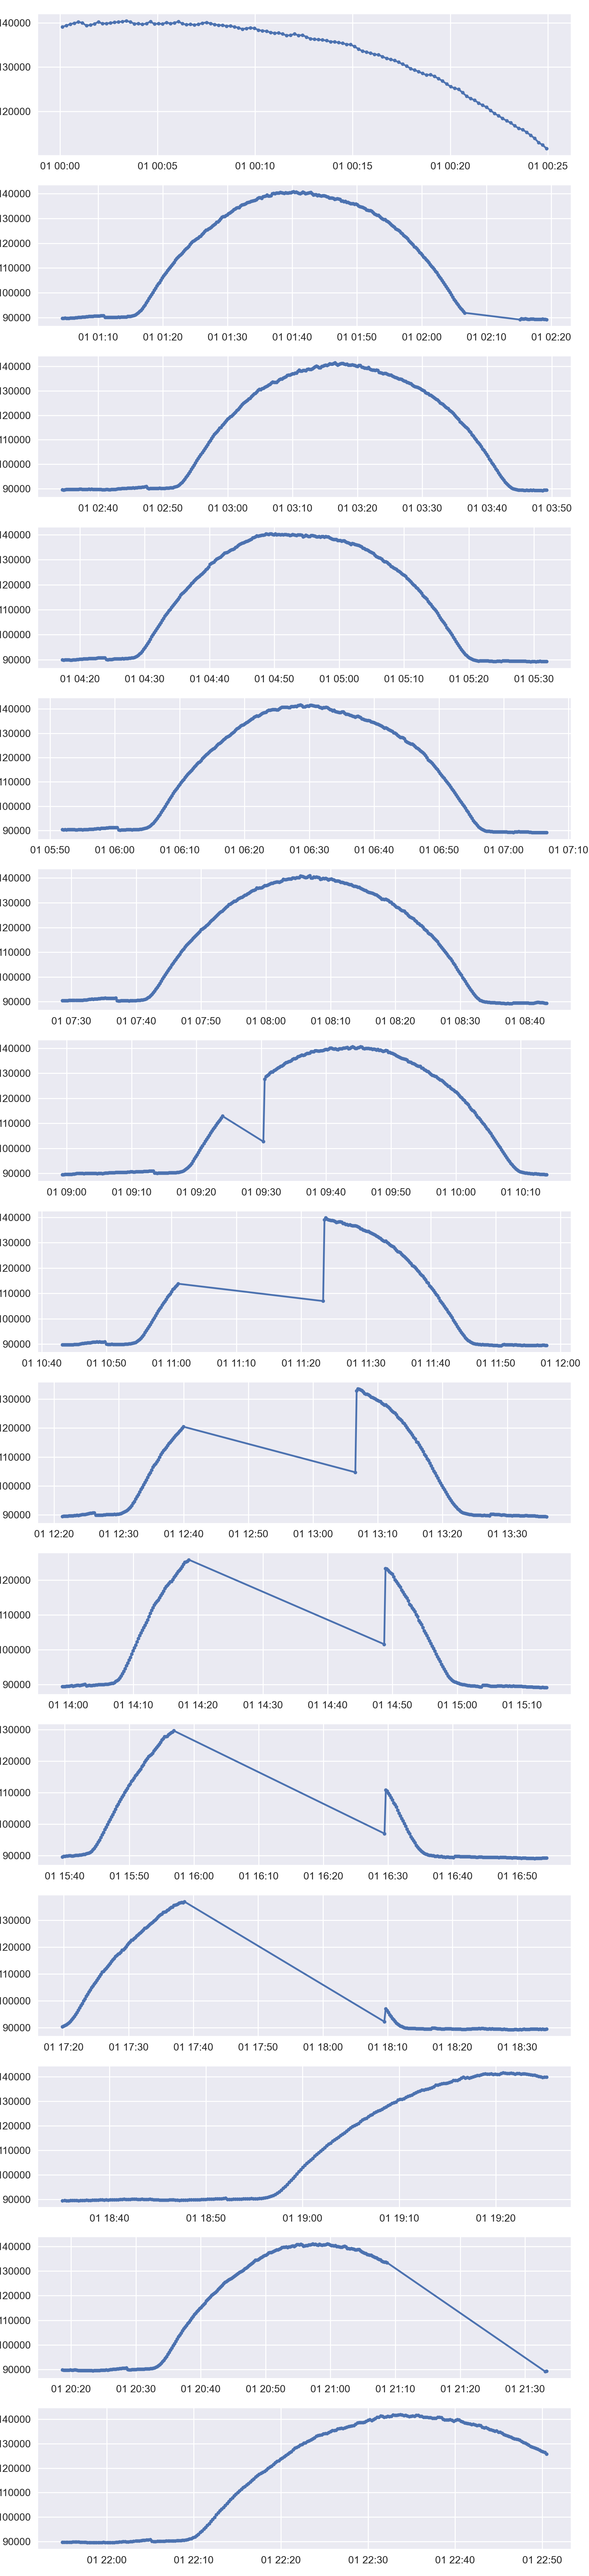

In [12]:
## JAN 1ST 
all_orbits = orbits_finder(df_01_p0)
# Trying to generate all orbit Subplots for a Specific Day
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15) = plt.subplots(nrows=15, ncols=1, figsize = (8,35))
plt.subplots_adjust(hspace=0.5)
fig.tight_layout()
#fig.suptitle("March 22nd, 2020", fontsize=18, y=0.95)

ax1.plot(single_orb(all_orbits,0)[0],single_orb(all_orbits,0)[1], marker = '.')
ax2.plot(single_orb(all_orbits,1)[0],single_orb(all_orbits,1)[1],marker = '.')
ax3.plot(single_orb(all_orbits,2)[0],single_orb(all_orbits,2)[1],marker = '.')
ax4.plot(single_orb(all_orbits,3)[0],single_orb(all_orbits,3)[1],marker = '.')
ax5.plot(single_orb(all_orbits,4)[0],single_orb(all_orbits,4)[1],marker = '.')
ax6.plot(single_orb(all_orbits,5)[0],single_orb(all_orbits,5)[1],marker = '.')
ax7.plot(single_orb(all_orbits,6)[0],single_orb(all_orbits,6)[1],marker = '.')
ax8.plot(single_orb(all_orbits,7)[0],single_orb(all_orbits,7)[1],marker = '.')
ax9.plot(single_orb(all_orbits,8)[0],single_orb(all_orbits,8)[1],marker = '.')
ax10.plot(single_orb(all_orbits,9)[0],single_orb(all_orbits,9)[1],marker = '.')
ax11.plot(single_orb(all_orbits,10)[0],single_orb(all_orbits,10)[1],marker = '.')
ax12.plot(single_orb(all_orbits,11)[0],single_orb(all_orbits,11)[1],marker = '.')
ax13.plot(single_orb(all_orbits,12)[0],single_orb(all_orbits,12)[1],marker = '.')
ax14.plot(single_orb(all_orbits,13)[0],single_orb(all_orbits,13)[1],marker = '.')
ax15.plot(single_orb(all_orbits,14)[0],single_orb(all_orbits,14)[1],marker = '.')

plt.savefig('Orbits of Jan 1st')

# Orbit 0

<IPython.core.display.Javascript object>


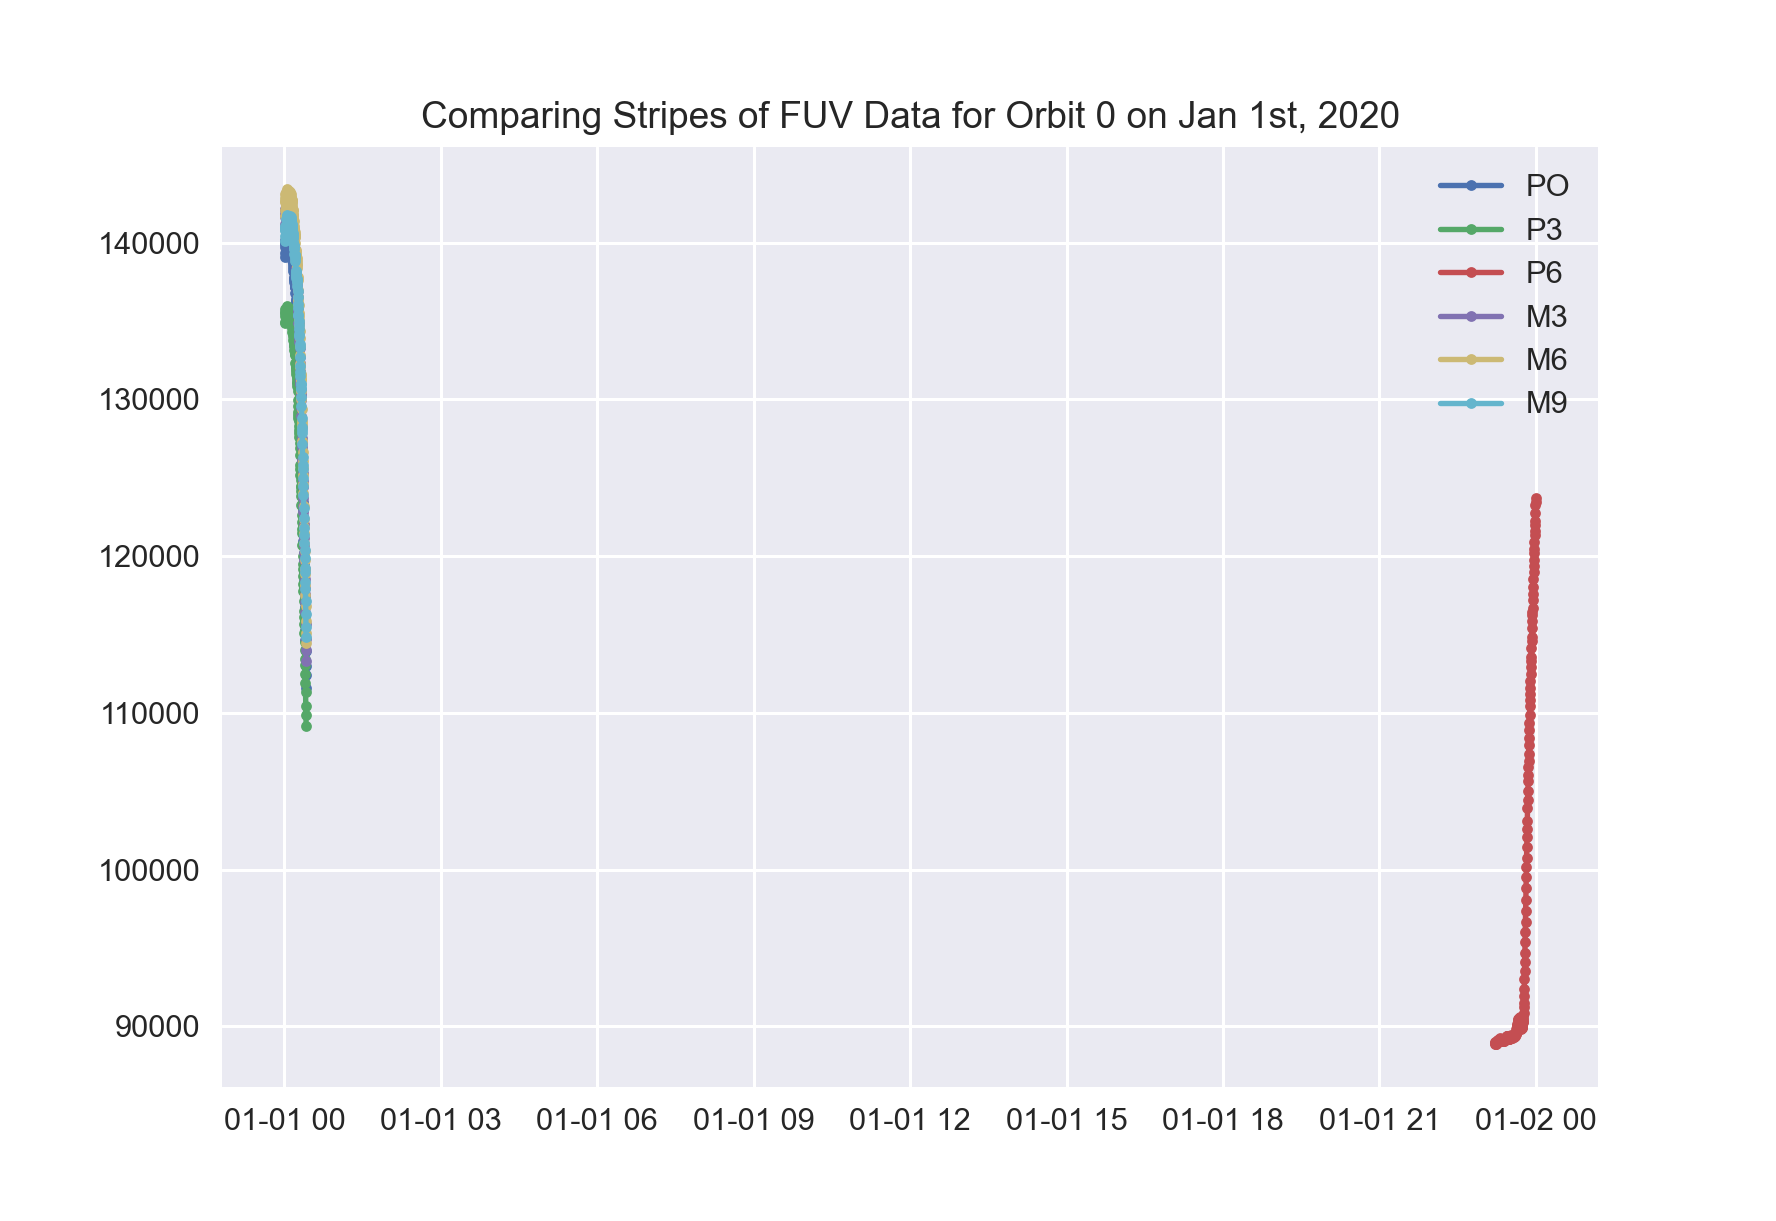

In [13]:
plt.figure()
plt.title("Comparing Stripes of FUV Data for Orbit 0 on Jan 1st, 2020")
plt.plot(single_orb(p_0_all_orbits,0)[0],single_orb(p_0_all_orbits,0)[1],marker = '.', label = 'PO')
plt.plot(single_orb(p_3_all_orbits,0)[0],single_orb(p_3_all_orbits,0)[1],marker = '.', label = 'P3')
plt.plot(single_orb(p_6_all_orbits,0)[0],single_orb(p_6_all_orbits,0)[1],marker = '.', label = 'P6')
plt.plot(single_orb(m_3_all_orbits,0)[0],single_orb(m_3_all_orbits,0)[1],marker = '.', label = 'M3')
plt.plot(single_orb(m_6_all_orbits,0)[0],single_orb(m_6_all_orbits,0)[1],marker = '.', label = 'M6')
plt.plot(single_orb(m_9_all_orbits,0)[0],single_orb(m_9_all_orbits,0)[1],marker = '.', label = 'M9')


plt.legend()
plt.show()

In [14]:
m3_o0 = orbits_finder(df_01_m3)[0]
m3_o0_label = 'M3'
m6_o0 = orbits_finder(df_01_m6)[0]
m6_o0_label = 'M6'
m9_o0 = orbits_finder(df_01_m9)[0]
m9_o0_label = 'M9'


p0_o0 = orbits_finder(df_01_p0)[0]
p0_o0_label = 'P0'
p3_o0 = orbits_finder(df_01_p3)[0]
p3_o0_label = 'P3'
p6_o0 = orbits_finder(df_01_p6)[0]
p6_o0_label = 'P6'

<IPython.core.display.Javascript object>


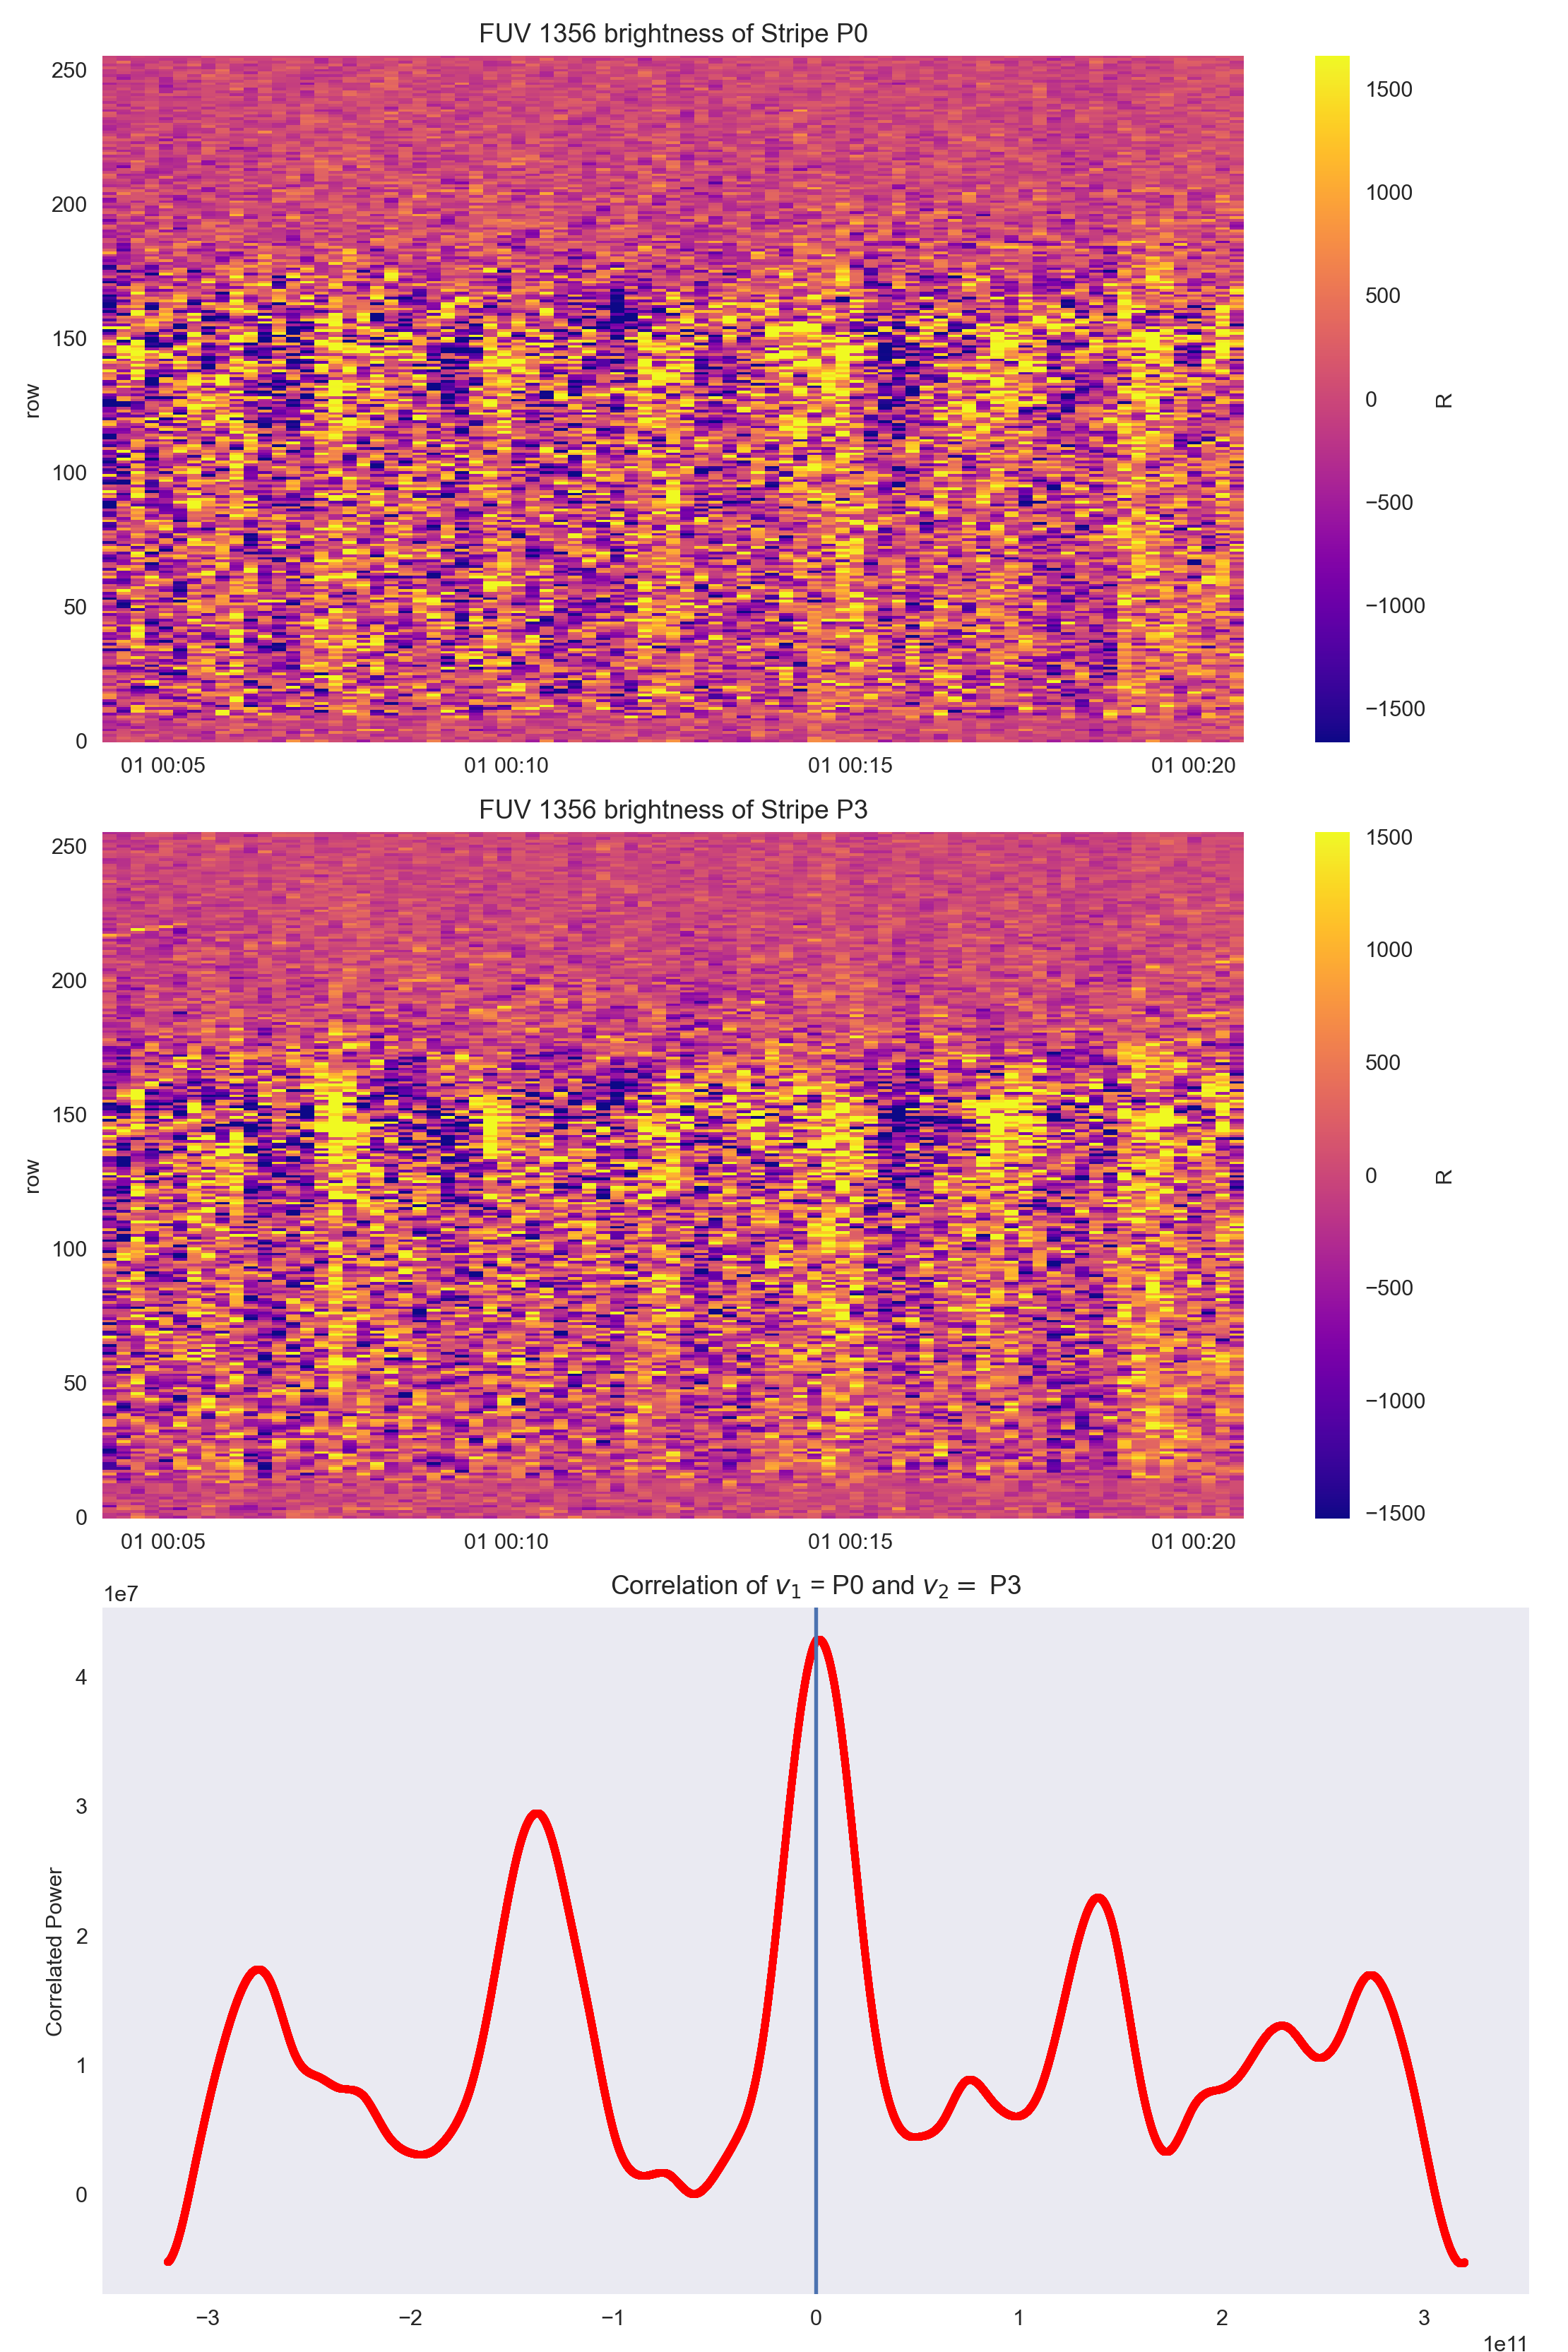

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [15]:
corr_fuvs_and_fuvs(p0_o0,p3_o0,p0_o0_label,p3_o0_label)

<IPython.core.display.Javascript object>


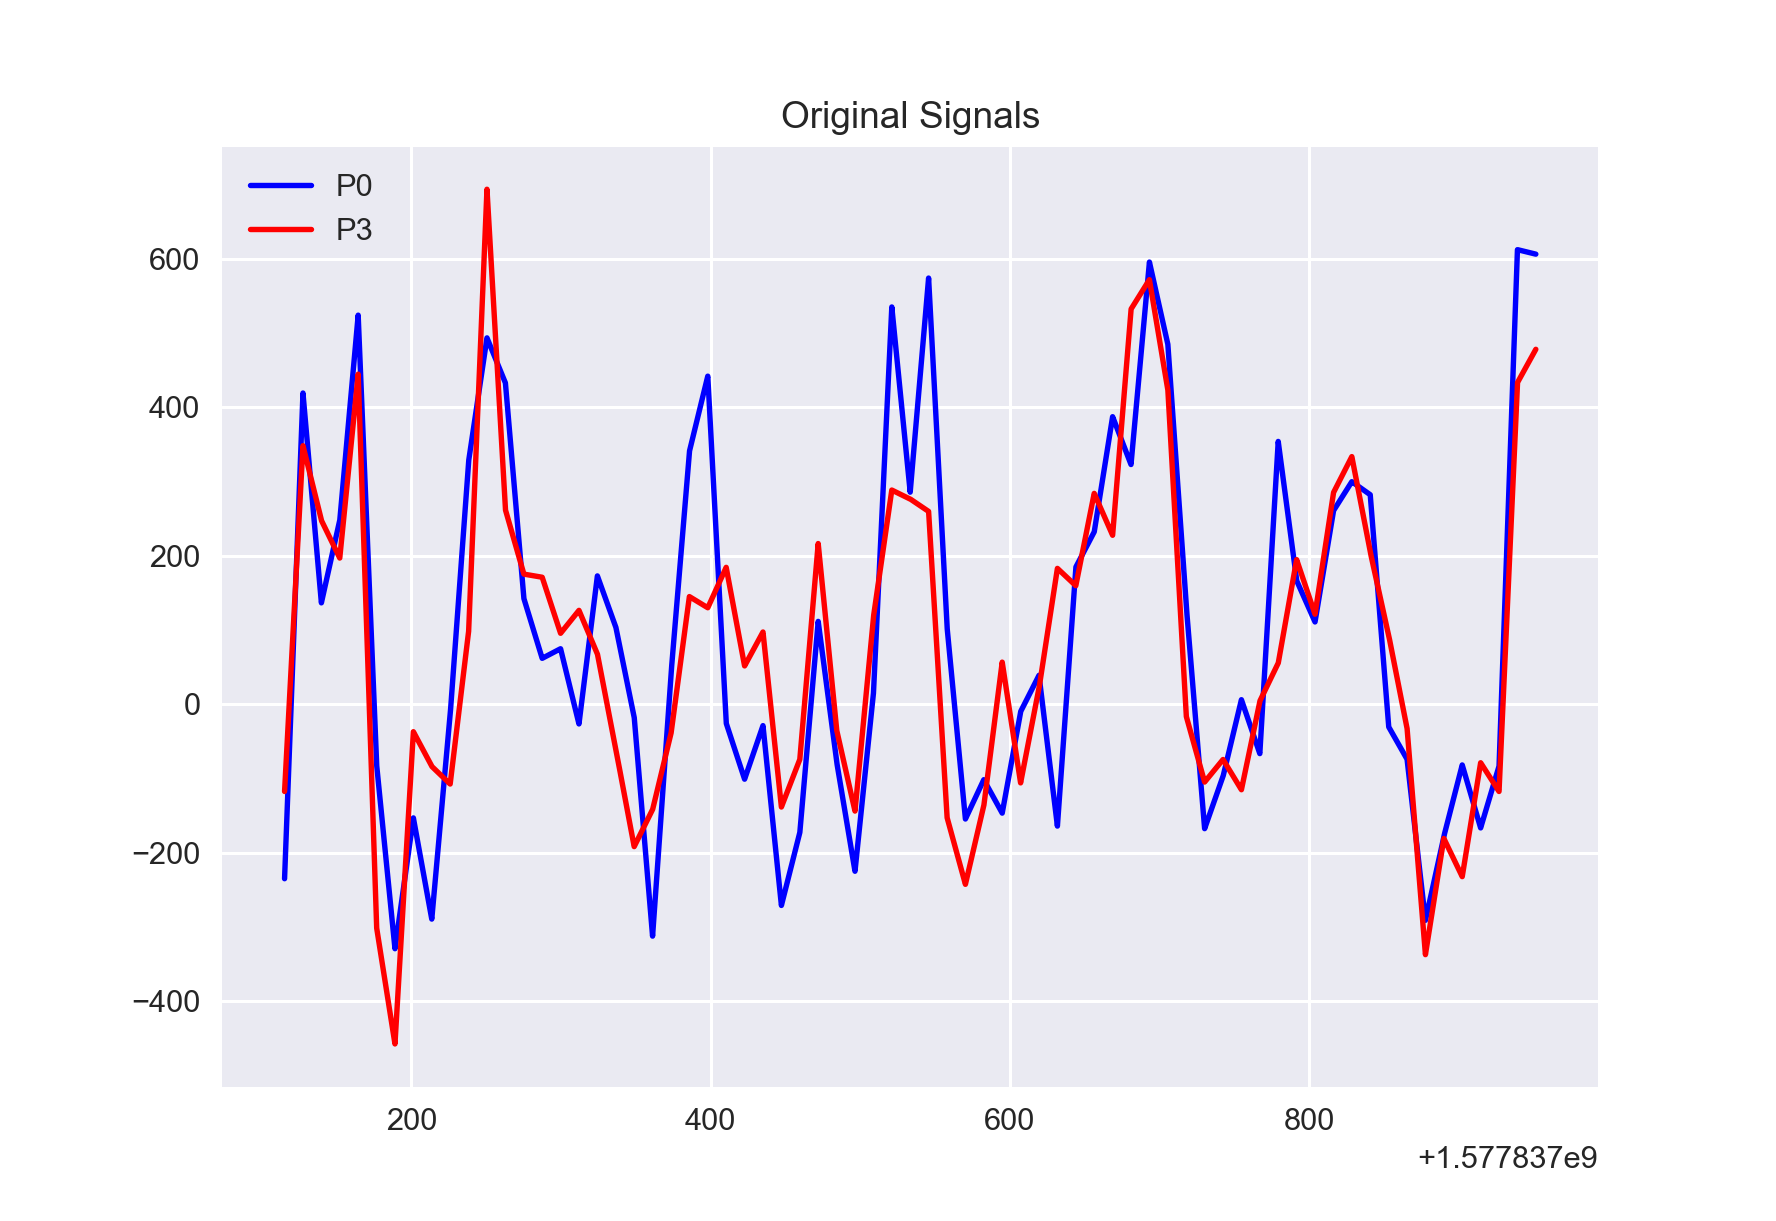

index 34500
xval 0.0
Difference from 0: 0.0


<IPython.core.display.Javascript object>


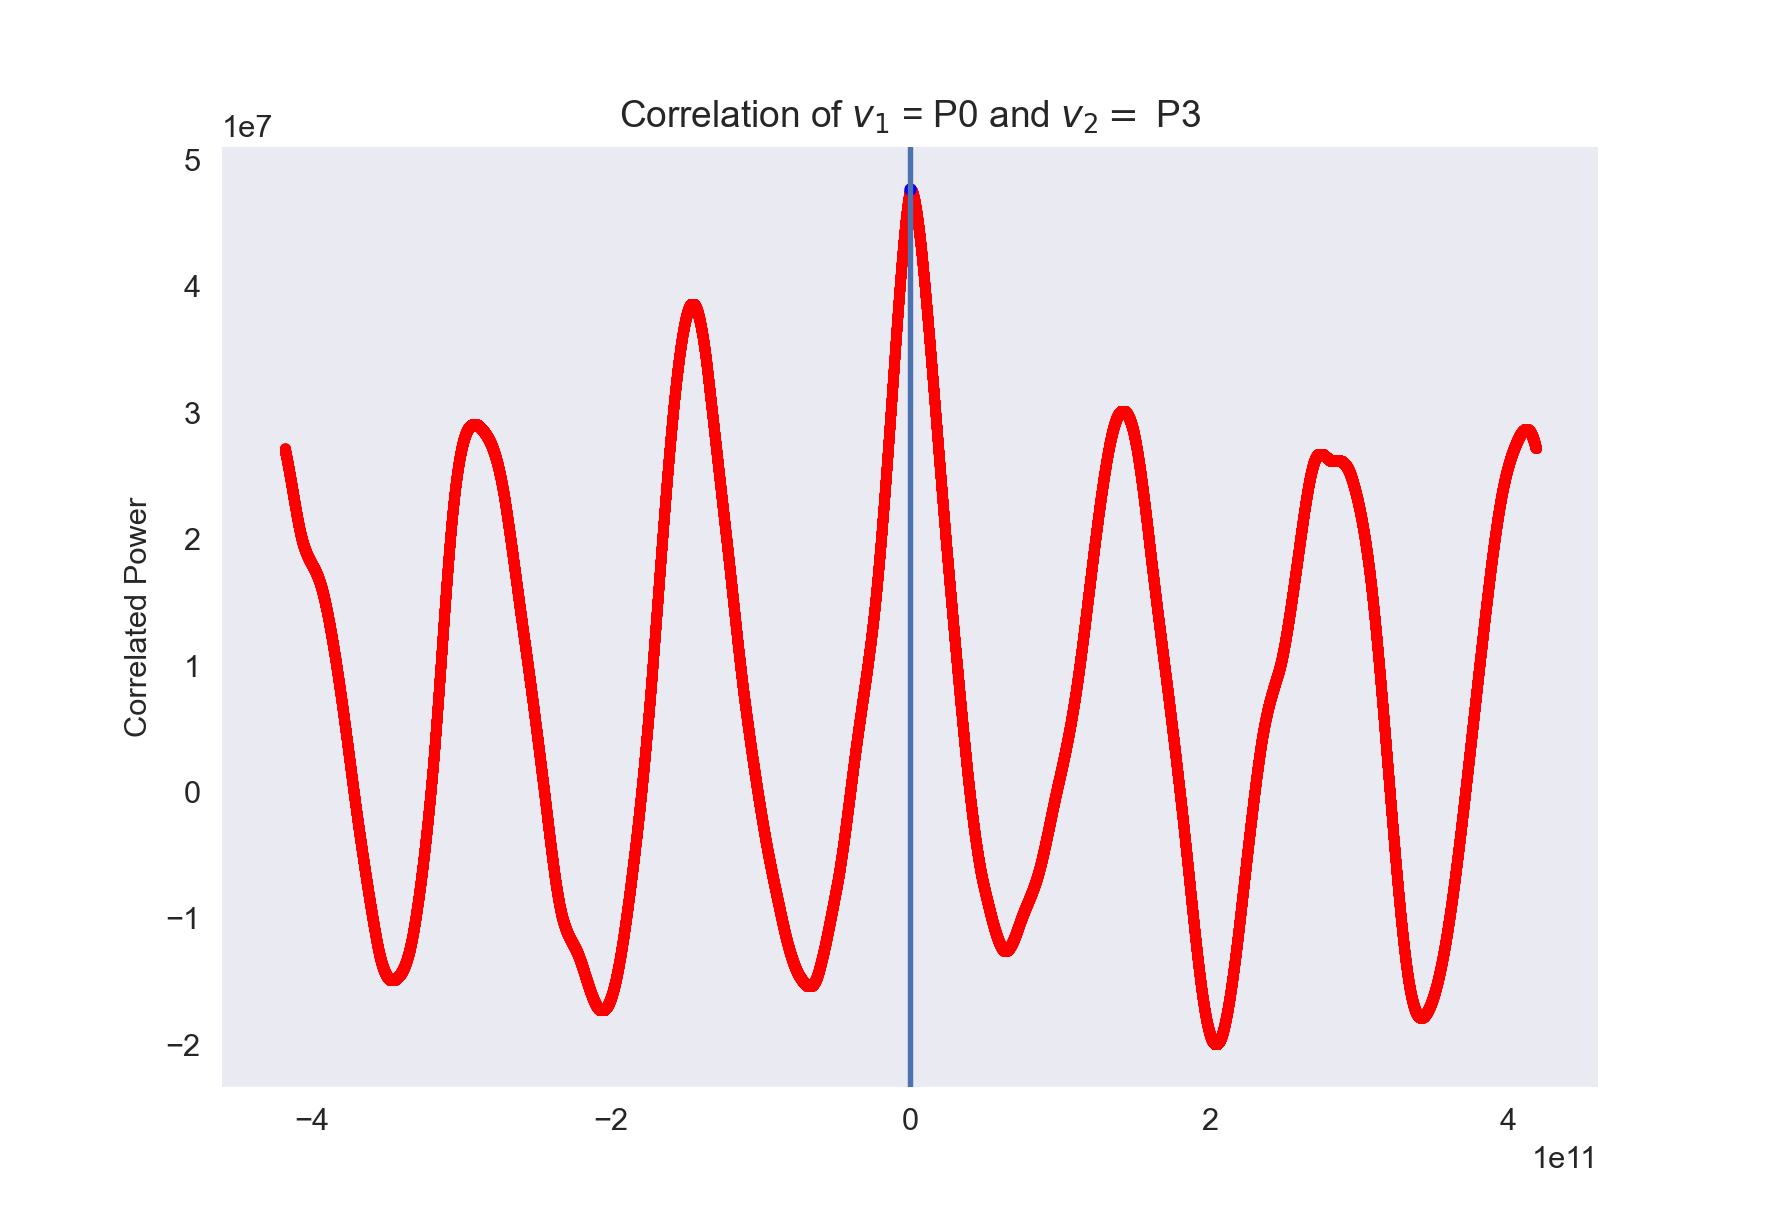

C:\Users\pkoll\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [16]:
correlations(p0_o0,p3_o0,p0_o0_label,p3_o0_label)

In [17]:
orbs_0 = [m9_o0,m6_o0,m3_o0,p0_o0,p3_o0,p6_o0]
labels_0 = [m9_o0_label,m6_o0_label,m3_o0_label,p0_o0_label,p3_o0_label,p6_o0_label]
angle_diffs_0_df = angle_diff(orbs_0,labels_0)
angle_diffs_0_df

ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:
offset_plots(angle_diffs_0_df)

# Orbit 1

In [ ]:
plt.figure()
plt.title("Comparing Stripes of FUV Data for Orbit 1 on Jan 1st, 2020")
plt.plot(single_orb(p_0_all_orbits,1)[0],single_orb(p_0_all_orbits,1)[1],marker = '.', label = 'PO')
plt.plot(single_orb(p_3_all_orbits,1)[0],single_orb(p_3_all_orbits,1)[1],marker = '.', label = 'P3')
plt.plot(single_orb(p_6_all_orbits,1)[0],single_orb(p_6_all_orbits,1)[1],marker = '.', label = 'P6')
plt.plot(single_orb(m_3_all_orbits,1)[0],single_orb(m_3_all_orbits,1)[1],marker = '.', label = 'M3')
plt.plot(single_orb(m_6_all_orbits,1)[0],single_orb(m_6_all_orbits,1)[1],marker = '.', label = 'M6')
plt.plot(single_orb(m_9_all_orbits,1)[0],single_orb(m_9_all_orbits,1)[1],marker = '.', label = 'M9')


plt.legend()
plt.show()

In [ ]:
m3_o1 = orbits_finder(df_01_m3)[1]
m3_o1_label = 'M3'
m6_o1 = orbits_finder(df_01_m6)[1]
m6_o1_label = 'M6'
m9_o1 = orbits_finder(df_01_m9)[1]
m9_o1_label = 'M9'


p0_o1 = orbits_finder(df_01_p0)[1]
p0_o1_label = 'P0'
p3_o1 = orbits_finder(df_01_p3)[1]
p3_o1_label = 'P3'
p6_o1 = orbits_finder(df_01_p6)[1]
p6_o1_label = 'P6'

In [ ]:
corr_fuvs_and_fuvs(p0_o1,p3_o1,p0_o1_label,p3_o1_label)

In [ ]:
correlations(p0_o1,p3_o1,p0_o1_label,p3_o1_label)

In [ ]:
correlations(m6_o1,p0_o1,m6_o1_label,p0_o1_label)

In [ ]:
orbs_1 = [m9_o1,m6_o1,m3_o1,p0_o1,p3_o1,p6_o1]
labels_1 = [m9_o1_label,m6_o1_label,m3_o1_label,p0_o1_label,p3_o1_label,p6_o1_label]
angle_diffs_1_df = angle_diff(orbs_1,labels_1)
angle_diffs_1_df

In [ ]:
offset_plots(angle_diffs_1_df)

# Orbit 2

In [ ]:
plt.figure()
plt.title("Comparing Stripes of FUV Data for Orbit 2 on Jan 1st, 2020")
plt.plot(single_orb(p_0_all_orbits,2)[0],single_orb(p_0_all_orbits,2)[1],marker = '.', label = 'PO')
plt.plot(single_orb(p_3_all_orbits,2)[0],single_orb(p_3_all_orbits,2)[1],marker = '.', label = 'P3')
plt.plot(single_orb(p_6_all_orbits,2)[0],single_orb(p_6_all_orbits,2)[1],marker = '.', label = 'P6')
plt.plot(single_orb(m_3_all_orbits,2)[0],single_orb(m_3_all_orbits,2)[1],marker = '.', label = 'M3')
plt.plot(single_orb(m_6_all_orbits,2)[0],single_orb(m_6_all_orbits,2)[1],marker = '.', label = 'M6')
plt.plot(single_orb(m_9_all_orbits,2)[0],single_orb(m_9_all_orbits,2)[1],marker = '.', label = 'M9')


plt.legend()
plt.show()

In [ ]:
m3_o2 = orbits_finder(df_01_m3)[2]
m3_o2_label = 'M3'
m6_o2 = orbits_finder(df_01_m6)[2]
m6_o2_label = 'M6'
m9_o2 = orbits_finder(df_01_m9)[2]
m9_o2_label = 'M9'


p0_o2 = orbits_finder(df_01_p0)[2]
p0_o2_label = 'P0'
p3_o2 = orbits_finder(df_01_p3)[2]
p3_o2_label = 'P3'
p6_o2 = orbits_finder(df_01_p6)[2]
p6_o2_label = 'P6'

In [ ]:
corr_fuvs_and_fuvs(p0_o2,p3_o2,p0_o2_label,p3_o2_label)

In [ ]:
correlations(p0_o2,p3_o2,p0_o2_label,p3_o2_label)

In [ ]:
orbs_2 = [m9_o2,m6_o2,m3_o2,p0_o2,p3_o2,p6_o2]
labels_2 = [m9_o2_label,m6_o2_label,m3_o2_label,p0_o2_label,p3_o2_label,p6_o2_label]

In [ ]:
angle_diffs_2_df = angle_diff(orbs_2,labels_2)
angle_diffs_2_df

In [ ]:
offset_plots(angle_diffs_2_df)

## MEGA FUNCTION FOR EVERYTHING ON JAN 1ST

In [ ]:
def everything(orbit_num):

    # ALL STRIPES PLOT
    plt.figure()
    plt.title("Comparing Stripes of FUV Data for Orbit " +str(orbit_num) + " on Jan 1st, 2020")
    plt.plot(single_orb(p_0_all_orbits,orbit_num)[0],single_orb(p_0_all_orbits,orbit_num)[1],marker = '.', label = 'PO')
    plt.plot(single_orb(p_3_all_orbits,orbit_num)[0],single_orb(p_3_all_orbits,orbit_num)[1],marker = '.', label = 'P3')
    plt.plot(single_orb(p_6_all_orbits,orbit_num)[0],single_orb(p_6_all_orbits,orbit_num)[1],marker = '.', label = 'P6')
    plt.plot(single_orb(m_3_all_orbits,orbit_num)[0],single_orb(m_3_all_orbits,orbit_num)[1],marker = '.', label = 'M3')
    plt.plot(single_orb(m_6_all_orbits,orbit_num)[0],single_orb(m_6_all_orbits,orbit_num)[1],marker = '.', label = 'M6')
    plt.plot(single_orb(m_9_all_orbits,orbit_num)[0],single_orb(m_9_all_orbits,orbit_num)[1],marker = '.', label = 'M9')

    plt.legend()
    plt.show()
    
    
    # FUVS
    m3 = orbits_finder(df_01_m3)[orbit_num]
    m3_label = 'M3'
    m6 = orbits_finder(df_01_m6)[orbit_num]
    m6_label = 'M6'
    m9 = orbits_finder(df_01_m9)[orbit_num]
    m9_label = 'M9'


    p0 = orbits_finder(df_01_p0)[orbit_num]
    p0_label = 'P0'
    p3 = orbits_finder(df_01_p3)[orbit_num]
    p3_label = 'P3'
    p6 = orbits_finder(df_01_p6)[orbit_num]
    p6_label = 'P6'
    
    # Corr and FUV- P0 P3
    corr_fuvs_and_fuvs(p0,p3,p0_label,p3_label)
    correlations(p0,p3,p0_label,p3_label)
    
    # Corr and FUV- P6 M9
    corr_fuvs_and_fuvs(p6,m9,p6_label,m9_label)
    correlations(p6,m9,p6_label,m9_label)
    
    # Angle Diffs Table
    all_orbs = [m9,m6,m3,p0,p3,p6]
    all_labels = [m9_label,m6_label,m3_label,p0_label,p3_label,p6_label]
    
    angle_diffs_df = angle_diff(all_orbs,all_labels)
    
    # Offset Plots
    offset_plots(angle_diffs_df)
    
    return angle_diffs_df

# Orbit 3

In [ ]:
everything(3)

# Orbit 15

In [ ]:
everything(14)